In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "GeBP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn030741,MASNRRPETEAQAGSSSEEEEGSSEENEDQEVSESESEEEKAPAPT...,388,1
1,Achn056961,MASEEDPTVYGEEDLDEDDEEDSEEDEGLTIPTSNPPQPDLDDDLD...,401,1
2,Achn082261,MAPNRLPEAEAQGSPSSDEEVEGESSEENESQSESDEEEDKTSTPS...,363,1
3,Achn111841,MASSRRPETEAQSGSSSEEEGSSEENEDQEVSESEEDKAPTPTRQK...,385,1
4,Achn176771,MPREIKNQNGKNVAQKPRIPTTPSSKQPAEKLPDKAAVETEQDPEV...,260,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
933,0.030172,0.000000,0.012931,0.010776,0.002155,0.021552,0.000000,0.004310,0.008621,0.004310,...,0.000000,0.002155,0.004310,0.002155,0.000000,0.000000,0.000000,0.0,0.0,0.0
1219,0.024324,0.002703,0.008108,0.002703,0.000000,0.013514,0.000000,0.000000,0.005405,0.008108,...,0.002703,0.000000,0.000000,0.002703,0.000000,0.002703,0.000000,0.0,0.0,0.0
1526,0.011765,0.000000,0.007843,0.003922,0.003922,0.000000,0.003922,0.007843,0.007843,0.003922,...,0.000000,0.003922,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0
1840,0.028571,0.000000,0.010714,0.003571,0.003571,0.000000,0.003571,0.000000,0.000000,0.007143,...,0.003571,0.003571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2110,0.004967,0.001656,0.004967,0.004967,0.000000,0.006623,0.001656,0.003311,0.000000,0.004967,...,0.003311,0.001656,0.001656,0.003311,0.000000,0.001656,0.001656,0.0,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2482, 441)
X_test: (621, 441)
y_train: (2482,)
y_test: (621,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step - accuracy: 0.5312 - loss: 0.6934

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6561 - loss: 0.6795 - val_accuracy: 0.8833 - val_loss: 0.5230


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8906 - loss: 0.5213

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9067 - loss: 0.4138 - val_accuracy: 0.9457 - val_loss: 0.1661


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1099

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1516 - val_accuracy: 0.9517 - val_loss: 0.1231


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1118

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9618 - loss: 0.1012 - val_accuracy: 0.9577 - val_loss: 0.1171


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1092

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9700 - loss: 0.0843 - val_accuracy: 0.9537 - val_loss: 0.1340


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.1041

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0724 - val_accuracy: 0.9638 - val_loss: 0.1244


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0180

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0464 - val_accuracy: 0.9638 - val_loss: 0.1117


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.1071

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1209 - val_accuracy: 0.9618 - val_loss: 0.1195


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0062

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0451 - val_accuracy: 0.9638 - val_loss: 0.1175


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0118

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0314 - val_accuracy: 0.9557 - val_loss: 0.1425


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0961

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0434 - val_accuracy: 0.9517 - val_loss: 0.1552


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0972

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0345 - val_accuracy: 0.9678 - val_loss: 0.1205


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.0933

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0264 - val_accuracy: 0.9658 - val_loss: 0.1281


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0039

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0166 - val_accuracy: 0.9577 - val_loss: 0.1394


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0271

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0223 - val_accuracy: 0.9618 - val_loss: 0.1382


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0130

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0157 - val_accuracy: 0.9557 - val_loss: 0.1520


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0038

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0116 - val_accuracy: 0.9678 - val_loss: 0.1325


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9557 - val_loss: 0.1709


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0163

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0139 - val_accuracy: 0.9638 - val_loss: 0.1422


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0341

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0189 - val_accuracy: 0.9618 - val_loss: 0.1537


Epoch 21/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0594

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0151 - val_accuracy: 0.9658 - val_loss: 0.1556


Epoch 22/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0082

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0100 - val_accuracy: 0.9537 - val_loss: 0.1802



[Train Accuracy: 99.80% - Test Accuracy: 95.17%]


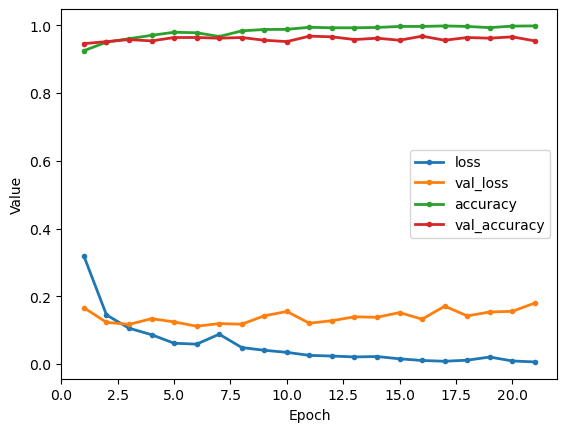

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
933,0.008639,0.0,0.000000,0.000000,0.000000,0.008639,0.000000,0.00216,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,0.010840,0.0,0.000000,0.000000,0.000000,0.002710,0.000000,0.00000,0.0,0.005420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003937,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1840,0.003584,0.0,0.000000,0.003584,0.003584,0.000000,0.000000,0.00000,0.0,0.007168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.000000,0.0,0.001658,0.001658,0.000000,0.001658,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2482, 8604)
X_test: (621, 8604)
y_train: (2482,)
y_test: (621,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,202,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,246,145 (8.57 MB)

 Trainable params: 2,246,145 (8.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 472ms/step - accuracy: 0.5000 - loss: 0.6932

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5074 - loss: 0.6930   

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5497 - loss: 0.6922

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6008 - loss: 0.6900

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6307 - loss: 0.6875 - val_accuracy: 0.9577 - val_loss: 0.6008


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9219 - loss: 0.6062

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9475 - loss: 0.5819 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9579 - loss: 0.5481

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9633 - loss: 0.5103

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9652 - loss: 0.4894 - val_accuracy: 0.9879 - val_loss: 0.0815


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.0753

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0681 

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9888 - loss: 0.0602

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9890 - loss: 0.0568

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9891 - loss: 0.0549 - val_accuracy: 0.9879 - val_loss: 0.0276


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0076

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0080 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0070

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0072

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0090 - val_accuracy: 0.9819 - val_loss: 0.0546


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0140

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0070 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0061

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0059

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9990 - loss: 0.0057 - val_accuracy: 0.9920 - val_loss: 0.0232


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0025

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0024 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0024

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0023

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9899 - val_loss: 0.0225


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0011

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7840e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5385e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6456e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6469e-04 - val_accuracy: 0.9839 - val_loss: 0.0272


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0012

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9281e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3156e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3275e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2531e-04 - val_accuracy: 0.9920 - val_loss: 0.0226


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.8843e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3193e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8758e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5249e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4224e-04 - val_accuracy: 0.9899 - val_loss: 0.0251


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.2397e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1447e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7999e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6205e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5125e-04 - val_accuracy: 0.9839 - val_loss: 0.0296


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.0611e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0876e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0868e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0788e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0915e-04 - val_accuracy: 0.9879 - val_loss: 0.0284


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6931e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3427e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6522e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8780e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9394e-04 - val_accuracy: 0.9899 - val_loss: 0.0260


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.2645e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0690e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1740e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2625e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3805e-04 - val_accuracy: 0.9899 - val_loss: 0.0272


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.3980e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9403e-05 

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0864e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1167e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1382e-04 - val_accuracy: 0.9839 - val_loss: 0.0321


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.3896e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2465e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1330e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1132e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2479e-04 - val_accuracy: 0.9899 - val_loss: 0.0246



[Train Accuracy: 100.00% - Test Accuracy: 99.03%]


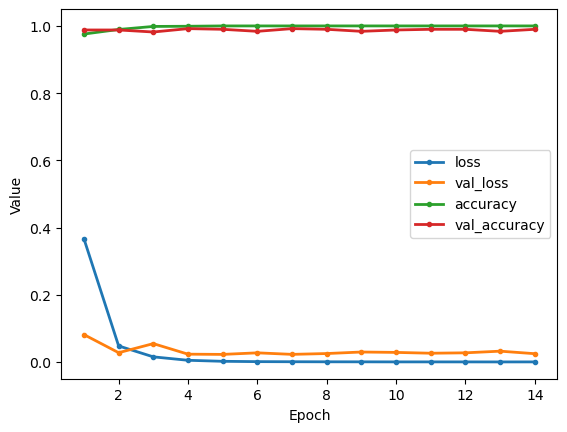

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
933,0.002165,0.0,0.0,0.0,0.0,0.002165,0.0,0.002165,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,0.005435,0.0,0.0,0.0,0.0,0.002717,0.0,0.000000,0.0,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1840,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.003597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,118,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,159,425 (126.49 MB)

 Trainable params: 33,159,425 (126.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 20s 648ms/step - accuracy: 0.5312 - loss: 0.6931

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5508 - loss: 0.6929  

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5547 - loss: 0.6928

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5547 - loss: 0.6927

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5519 - loss: 0.6926

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5510 - loss: 0.6925

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5485 - loss: 0.6925

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5459 - loss: 0.6925

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5433 - loss: 0.6926

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5405 - loss: 0.6926

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5384 - loss: 0.6926

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5364 - loss: 0.6926

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5340 - loss: 0.6926

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5316 - loss: 0.6926

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5295 - loss: 0.6926

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5282 - loss: 0.6925

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5273 - loss: 0.6925

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5266 - loss: 0.6924

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5263 - loss: 0.6923

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5261 - loss: 0.6923

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5263 - loss: 0.6922

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5267 - loss: 0.6920

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5269 - loss: 0.6919

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5276 - loss: 0.6918

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5284 - loss: 0.6916

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5296 - loss: 0.6914

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5311 - loss: 0.6912

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5328 - loss: 0.6910

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5348 - loss: 0.6908

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5370 - loss: 0.6905

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5391 - loss: 0.6902

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5430 - loss: 0.6897 - val_accuracy: 0.8370 - val_loss: 0.6327


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8594 - loss: 0.6302

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8516 - loss: 0.6311 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8594 - loss: 0.6297

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8691 - loss: 0.6278

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8791 - loss: 0.6257

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8879 - loss: 0.6235

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8941 - loss: 0.6213

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8988 - loss: 0.6192

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9025 - loss: 0.6170

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9054 - loss: 0.6147

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9075 - loss: 0.6124

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9084 - loss: 0.6102

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9090 - loss: 0.6081

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9093 - loss: 0.6059

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9099 - loss: 0.6036

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9106 - loss: 0.6011

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9113 - loss: 0.5986

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9119 - loss: 0.5960

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9127 - loss: 0.5931

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9134 - loss: 0.5902

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9140 - loss: 0.5872

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9146 - loss: 0.5843

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9151 - loss: 0.5813

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9156 - loss: 0.5783

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9162 - loss: 0.5752

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9168 - loss: 0.5720

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9174 - loss: 0.5688

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9180 - loss: 0.5656

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9186 - loss: 0.5623

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9193 - loss: 0.5589

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9199 - loss: 0.5556

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9211 - loss: 0.5494 - val_accuracy: 0.9618 - val_loss: 0.2136


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 1.0000 - loss: 0.1568

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.1592 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.1590

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9990 - loss: 0.1575

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9980 - loss: 0.1561

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9974 - loss: 0.1540

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9972 - loss: 0.1516

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9968 - loss: 0.1491

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9966 - loss: 0.1464

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9961 - loss: 0.1441

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9957 - loss: 0.1417

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9954 - loss: 0.1393

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9952 - loss: 0.1369

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9951 - loss: 0.1344

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9950 - loss: 0.1320

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9949 - loss: 0.1297

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9949 - loss: 0.1274

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9949 - loss: 0.1252

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9949 - loss: 0.1231

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9949 - loss: 0.1210

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9950 - loss: 0.1190

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9950 - loss: 0.1171

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9950 - loss: 0.1152

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9951 - loss: 0.1134

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9951 - loss: 0.1117

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9952 - loss: 0.1100

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9952 - loss: 0.1084

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9953 - loss: 0.1068

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9953 - loss: 0.1053

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9954 - loss: 0.1038

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9954 - loss: 0.1024

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9955 - loss: 0.0999 - val_accuracy: 0.9960 - val_loss: 0.0464


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 1.0000 - loss: 0.0131

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.0116

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0109

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0104

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0100

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0096

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0093

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0090

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0087

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0085

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0083

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0081

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0079

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0078

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0077

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0076

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0074

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0074

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9999 - loss: 0.0073

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9999 - loss: 0.0073

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9998 - loss: 0.0072

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9998 - loss: 0.0071

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9998 - loss: 0.0071

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9998 - loss: 0.0070

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9998 - loss: 0.0069

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9998 - loss: 0.0069

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0068

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0068

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0067

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0066

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0066

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9997 - loss: 0.0065 - val_accuracy: 0.9899 - val_loss: 0.0248


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0030

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.0029

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.0027

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0025

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0024

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0023

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0023

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0022

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0022

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0021

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0021

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0021

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0021

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0021

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0020

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0020

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0020

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0020

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0020

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9859 - val_loss: 0.0308


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0020

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.0019

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0017

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0015

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0014

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0014

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0014

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0013

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0013

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0013

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0013

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0013

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0012

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0012

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0012

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0011

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0011

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0011

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9920 - val_loss: 0.0213


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 5.0367e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 5.3689e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.5344e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7015e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7817e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.8663e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.8849e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.8699e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.8362e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7926e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7368e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7445e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7497e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7566e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7595e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7543e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.7489e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7571e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7529e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7443e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7312e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7306e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7278e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7209e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7145e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7085e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7036e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.6989e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7010e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7006e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.6988e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 5.6954e-04 - val_accuracy: 0.9899 - val_loss: 0.0212


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 5.5608e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 5.2337e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.9961e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.7642e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.6035e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.4884e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.3817e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.3206e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2975e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2707e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2836e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2877e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2876e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2784e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2679e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2513e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2860e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.3130e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.3390e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.3597e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.3786e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.4050e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.4271e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.4499e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.4887e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.5205e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.5474e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.5688e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.5866e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.6036e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.6171e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 4.6416e-04 - val_accuracy: 0.9899 - val_loss: 0.0203


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 2.3554e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 2.5040e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.4602e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.4813e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.4846e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.5987e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.7709e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.8868e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.9658e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.0120e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.0863e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.1360e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.1643e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.1805e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.1922e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.1998e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.1997e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1975e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1937e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1881e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1870e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1857e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1849e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1807e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1767e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1720e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1655e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1591e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1533e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1456e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.1370e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 3.1211e-04 - val_accuracy: 0.9899 - val_loss: 0.0197


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 1.9942e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 3.6009e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.6971e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.5923e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.4609e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.3701e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.3018e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.2457e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.1937e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.1369e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.0749e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.0133e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.9506e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.8961e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.8486e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.8062e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.7662e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.7304e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.6952e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.6610e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.6298e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.5999e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.5730e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.5469e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.5217e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.4974e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.4745e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.4535e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.4348e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.4164e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.3982e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.3651e-04 - val_accuracy: 0.9899 - val_loss: 0.0205


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 1.3763e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 1.6682e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 1.6099e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6736e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6582e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6374e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6377e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6256e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6081e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5917e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5800e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5711e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5685e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5688e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5718e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5737e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5745e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5761e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5759e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5927e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6048e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6144e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6216e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6258e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6278e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6287e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6297e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6294e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6283e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6262e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6236e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 1.6189e-04 - val_accuracy: 0.9940 - val_loss: 0.0173


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 7.6645e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 1.3794e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 1.4752e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.6396e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6787e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6709e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6405e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.6069e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5704e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5435e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5302e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5176e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5190e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5187e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5197e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5179e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.5139e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5085e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5011e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4932e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4853e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4772e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4699e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4623e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4546e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4467e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4387e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4303e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4214e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4124e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4058e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 1.3937e-04 - val_accuracy: 0.9940 - val_loss: 0.0170


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 5.4975e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 8.4934e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.1316e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.3151e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.2654e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.1394e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.9718e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.7780e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.7319e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.6751e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.6129e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5850e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5581e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5439e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5473e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5332e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5059e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.4866e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.4597e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.4357e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.4010e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.3801e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.3575e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.3328e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.3095e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.3002e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.2991e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.2970e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.2968e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.2951e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.3398e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.4209e-05 - val_accuracy: 0.9899 - val_loss: 0.0197



[Train Accuracy: 100.00% - Test Accuracy: 98.87%]


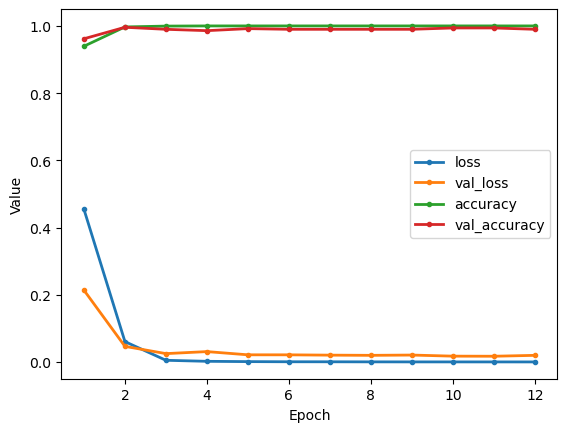

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/GeBP/report_3JERWUWS.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################